In [53]:
import itertools
from rl.returns import returns
import rl.markov_process as mp
from typing import Iterable, Iterator, Tuple, TypeVar, Dict, Callable,List
from rl.distribution import Choose
from IPython.display import clear_output
import matplotlib.pyplot as plt
from rl.function_approx import FunctionApprox

## Write a function mc_tabular for Tabular TD lambda Prediction.


In [81]:
S = TypeVar('S')
def td_lambda_tabular(traces: Iterable[Iterable[mp.TransitionStep[S]]],
        gamma: float,
        lambd: float,
        learning_rate: Callable[[int],float],
        episode_length: int,
        num_episode: int,
        initial_value_function: Dict
        )->Dict[S, Iterable[float]]:

    V = initial_value_function
    V_record = {}
    count = {}
    temp = 0
    for trace in itertools.islice(traces,num_episode):
        temp += 1

        if temp%100 == 0:
            print(temp)
            clear_output(wait=True)

        Et = {}
        for step in itertools.islice(trace,episode_length):

            count[step.state] = count.get(step.state,0) + 1
            delta_t  = step.reward + gamma*V.get(step.next_state,0.)-V.get(step.state,0.)


            Et[step.state] = 1 + gamma*lambd*Et.get(step.state,0.0)

            for old_state in Et.keys():
                if old_state != step.state:
                    Et[old_state] = Et[old_state]*gamma*lambd

            alpha = learning_rate(count.get(step.state,0))
            V[step.state] = V.get(step.state,0.) + alpha*delta_t*Et[step.state]
            for old_state in V.keys():
                if old_state != step.state:
                    alpha = learning_rate(count.get(old_state,0))
                    V[old_state] = V[old_state] + alpha*delta_t*Et.get(old_state,0)
        for key in V.keys():
            V_record[key] = V_record.get(key,[])+[V[key]]
    return V_record

## Use 1D random walk in the textbook as an example MRP

In [82]:
from rl.chapter10.random_walk_mrp import RandomWalkMRP

this_barrier: int = 10
this_p: float = 0.5
random_walk: RandomWalkMRP = RandomWalkMRP(
        barrier=this_barrier,
        p=this_p
    )
initial_vf_dict={s: 0.5 for s in random_walk.non_terminal_states}

## To compare with the results in the textbook, using the same initial learning rate(0.05), half life and exp. Simulate the value function with $\lambda = 0,0.1,0.5,0.9,1.0$. Plot the RMSE

In [83]:
from rl.function_approx import learning_rate_schedule
from rl.chapter10.prediction_utils import fmrp_episodes_stream
episode_length: int = 5000
num_episode: int = 700
initial_learning_rate: float = 0.05
half_life: float = 1e8
exponent: float = 0.5
gamma: float = 1.0

episodes: Iterable[Iterable[mp.TransitionStep[S]]] = fmrp_episodes_stream(random_walk)
learning_rate_func: Callable[[int], float] = learning_rate_schedule( initial_learning_rate=initial_learning_rate, half_life=half_life, exponent=exponent)
values_TD = td_lambda_tabular(traces = episodes,
        gamma=gamma,
        lambd = 0.,
        learning_rate = learning_rate_func,
        episode_length=episode_length,
        num_episode= num_episode,
        initial_value_function=initial_vf_dict
        )

values_MC = td_lambda_tabular(traces = episodes,
        gamma=gamma,
        lambd = 1.,
        learning_rate = learning_rate_func,
        episode_length=episode_length,
        num_episode= num_episode,
        initial_value_function=initial_vf_dict
        )

values_lamda1 = td_lambda_tabular(traces = episodes,
        gamma=gamma,
        lambd = 0.1,
        learning_rate = learning_rate_func,
        episode_length=episode_length,
        num_episode= num_episode,
        initial_value_function=initial_vf_dict
        )

values_lamda5 = td_lambda_tabular(traces = episodes,
        gamma=gamma,
        lambd = 0.5,
        learning_rate = learning_rate_func,
        episode_length=episode_length,
        num_episode= num_episode,
        initial_value_function=initial_vf_dict
        )

values_lamda9 = td_lambda_tabular(traces = episodes,
        gamma=gamma,
        lambd = 0.9,
        learning_rate = learning_rate_func,
        episode_length=episode_length,
        num_episode= num_episode,
        initial_value_function=initial_vf_dict
        )

700


Text(0, 0.5, 'Value Function RMSE')

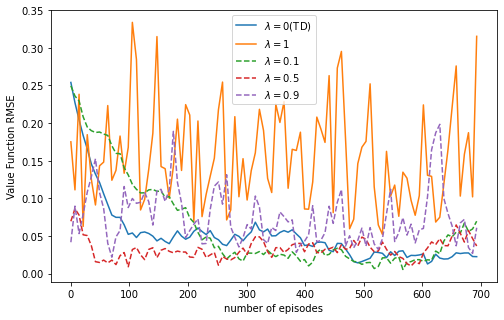

In [92]:
ground_truth ={random_walk.non_terminal_states[i]: round(v, 3)
            for i, v in enumerate(random_walk.get_value_function_vec(gamma))}

rmse_TD = []
for k in range(len(values_TD[1])):
    temp = 0
    for state in values_TD.keys():
        temp += (values_TD[state][k]-ground_truth[state])**2
    temp /= len(values_TD)
    temp **= 1/2
    rmse_TD += [temp]

rmse_MC = []
for k in range(len(values_MC[1])):
    temp = 0
    for state in values_MC.keys():
        temp += (values_MC[state][k]-ground_truth[state])**2
    temp /= len(values_MC)
    temp **= 1/2
    rmse_MC += [temp]

rmse_lamda1 = []
for k in range(len(values_lamda1[1])):
    temp = 0
    for state in values_lamda1.keys():
        temp += (values_lamda1[state][k]-ground_truth[state])**2
    temp /= len(values_lamda1)
    temp **= 1/2
    rmse_lamda1 += [temp]

rmse_lamda5 = []
for k in range(len(values_lamda5[1])):
    temp = 0
    for state in values_lamda5.keys():
        temp += (values_lamda5[state][k]-ground_truth[state])**2
    temp /= len(values_lamda5)
    temp **= 1/2
    rmse_lamda5 += [temp]

rmse_lamda9 = []
for k in range(len(values_lamda9[1])):
    temp = 0
    for state in values_lamda9.keys():
        temp += (values_lamda9[state][k]-ground_truth[state])**2
    temp /= len(values_lamda9)
    temp **= 1/2
    rmse_lamda9 += [temp]

xx = range(num_episode)
plt.figure(figsize=(8,5))
plt.plot(xx[:num_episode:7],rmse_TD[:num_episode:7],label = '$\lambda = 0$(TD)')
plt.plot(xx[:num_episode:7],rmse_MC[:num_episode:7],label = '$\lambda = 1$')
plt.plot(xx[:num_episode:7],rmse_lamda1[:num_episode:7],'--',label = '$\lambda = 0.1$')
plt.plot(xx[:num_episode:7],rmse_lamda5[:num_episode:7],'--',label = '$\lambda = 0.5$')
plt.plot(xx[:num_episode:7],rmse_lamda9[:num_episode:7],'--',label = '$\lambda = 0.9$')
plt.legend()
plt.xlabel('number of episodes')
plt.ylabel('Value Function RMSE')



## Comparison
The blue and orange line above are simulations with $\lambda = 0$ and $\lambda = 1$ respectively.
They shows identical behaviors as the Figure 9.1 in the textbook. $\lambda = 0$ case is TD, which has lower variance and $\lambda = 1$ mimics MC.
The dashed line are different $\lambda$. We can see they are intermediate states between TD and MC. The cases with smaller $\lambda$ are more like TD while the cases with large $\lambda$ are more like MC


## Extend to Function Approximation

In [ ]:
S = TypeVar('S')
def td_lambda_function_approx(traces: Iterable[Iterable[mp.TransitionStep[S]]],
        gamma: float,
        lambd: float,
        learning_rate: Callable[[int],float],
        episode_length: int,
        num_episode: int,
        initial_value_function: FunctionApprox[S]
        )->Dict[S, Iterable[float]]:

    V = initial_value_function
    V_record = {}
    count = {}
    temp = 0
    for trace in itertools.islice(traces,num_episode):

        Et = {}
        for step in itertools.islice(trace,episode_length):

            count[step.state] = count.get(step.state,0) + 1
            delta_t  = step.reward + gamma*V.get(step.next_state,0.)-V.get(step.state,0.)


            Et[step.state] = 1 + gamma*lambd*Et.get(step.state,0.0)

            for old_state in Et.keys():
                if old_state != step.state:
                    Et[old_state] = Et[old_state]*gamma*lambd

            alpha = learning_rate(count.get(step.state,0))
            V[step.state] = V.get(step.state,0.) + alpha*delta_t*Et[step.state]
            for old_state in V.keys():
                if old_state != step.state:
                    alpha = learning_rate(count.get(old_state,0))
                    V[old_state] = V[old_state] + alpha*delta_t*Et.get(old_state,0)
        for key in V.keys():
            V_record[key] = V_record.get(key,[])+[V[key]]
    return V_record